### Training separate ARIMA models for each city

References - https://medium.com/analysts-corner/comprehensive-guide-to-time-series-modeling-techniques-applications-and-best-practices-fd330eb0a755

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error

## Load datsets of each location

In [121]:
bibile_df = pd.read_csv('ML Dataset\\bibile,_monaragala_data.csv')
colombo_df = pd.read_csv('ML Dataset\\colombo_proper_data.csv')
deniyaya_df = pd.read_csv('ML Dataset\\deniyaya,_matara_data.csv')
jaffna_df = pd.read_csv('ML Dataset\\jaffna_proper_data.csv')
kandy_df = pd.read_csv('ML Dataset\\kandy_proper_data.csv')
kurunegala_df = pd.read_csv('ML Dataset\\kurunegala_proper_data.csv')
nuwara_eliya_df = pd.read_csv('ML Dataset\\nuwara_eliya_proper_data.csv')

# Bibile, Monaragala ARIMA model

In [122]:
bibile_df.head()

,HCHO_reading,Location,Current_Date,Next_Date
0,0.000019,"bibile, monaragala",2019-01-02,2019-01-03
1,0.000028,"bibile, monaragala",2019-01-03,2019-01-04
2,0.000037,"bibile, monaragala",2019-01-04,2019-01-05
3,0.000037,"bibile, monaragala",2019-01-05,2019-01-06
4,0.000146,"bibile, monaragala",2019-01-06,2019-01-07


In [123]:
bibile_df.dtypes

HCHO_reading    float64
Location         object
Current_Date     object
Next_Date        object
dtype: object

In [124]:
# convert current_date dtype as datetime
bibile_df['Current_Date'] = pd.to_datetime(bibile_df['Current_Date'])

In [125]:
bibile_df.dtypes

HCHO_reading           float64
Location                object
Current_Date    datetime64[ns]
Next_Date               object
dtype: object

We are training an ARIMA model specifically for the 'bibile, monaragala' location, so don't need the 'Location' column since it contains the same value for all rows ('bibile, monaragala'). Additionally, the ARIMA model doesn't require knowledge of the specific dates of future data points during training. So we can exclude 'Next_Date' column as well.

In [126]:
# drop the 'Location' and 'Next_Date' columns
bibile_df = bibile_df.drop(['Location', 'Next_Date'], axis=1)

In [127]:
bibile_df.head()

,HCHO_reading,Current_Date
0,0.000019,2019-01-02
1,0.000028,2019-01-03
2,0.000037,2019-01-04
3,0.000037,2019-01-05
4,0.000146,2019-01-06


In [128]:
bibile_df.dtypes

HCHO_reading           float64
Current_Date    datetime64[ns]
dtype: object

Set 'Current_Date' as the index because we are working with time series data, as it aligns well with the principles and requirements of time series analysis and modeling.

References - https://mlpills.dev/time-series/date-manipulation-in-python-for-time-series/#:~:text=In%20time%20series%20analysis%2C%20leveraging,index%20using%20the%20set_index%20method.

In [129]:
# set 'Current_Date' as the index 
bibile_df.set_index('Current_Date', inplace=True)

In [130]:
bibile_df.head()

,HCHO_reading
Current_Date,
2019-01-02,0.000019
2019-01-03,0.000028
2019-01-04,0.000037
2019-01-05,0.000037
2019-01-06,0.000146


In [131]:
bibile_df.describe()

,HCHO_reading
count,1.825000e+03
mean,1.331636e-04
std,8.052639e-05
min,1.461232e-07
25%,7.099799e-05
50%,1.241180e-04
75%,1.850499e-04
max,3.561278e-04


## Model Training

Automatically select ARIMA model parameters using auto_arima model and fits the ARIMA model to the training data.

In time series forecasting tasks it's essential to split the data sequentially to preserve the temporal order.

In [132]:
# split the data into training and testing sets without shuffling
train_size = 0.8

train_bibile, test_bibile = train_test_split(bibile_df, train_size=train_size, shuffle=False)

### Auto Arima model

In [133]:
# Fit the auto-ARIMA model
auto_arima_bibile = auto_arima(train_bibile, seasonal=False, trace=True)

Performing stepwise search to minimize aic


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-23821.848, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-21446.918, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-23640.936, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-22415.704, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-23829.885, Time=0.52 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-22862.566, Time=0.33 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-23792.731, Time=0.33 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-23858.515, Time=0.57 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-23016.996, Time=0.58 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-23855.898, Time=0.53 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-23860.674, Time=0.65 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=-23160.435, Time=0.57 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-23870.000, Time=0.73 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=-23857.241, Time=0.82 sec
 ARIMA(2,0,5)(0,0,0)[0]             : AIC=-23862

### ARIMA Model

In [134]:
# extract order parameters (p, d, q) from auto-ARIMA model
p, d, q = auto_arima_bibile.order
print(p, d, q)

4 0 5


In [135]:
# train ARIMA model with extracted order parameters
bibile_arima_model = ARIMA(train_bibile, order=(p, d, q))
bibile_arima_fit = bibile_arima_model.fit()

C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCac

There might be an issue with the optimization process during training of the ARIMA model.

In [136]:
print(bibile_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           HCHO_reading   No. Observations:                 1460
Model:                 ARIMA(4, 0, 5)   Log Likelihood               11978.513
Date:                Sat, 20 Apr 2024   AIC                         -23935.027
Time:                        18:40:51   BIC                         -23876.879
Sample:                    01-02-2019   HQIC                        -23913.335
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   6.13e-06     21.771      0.000       0.000       0.000
ar.L1          0.3932   8.74e-10    4.5e+08      0.000       0.393       0.393
ar.L2          0.2288      5e-10   4.58e+08      0.0

Analyze residuals(errors) of the fitted ARIMA model on training data.

<Axes: xlabel='Current_Date'>

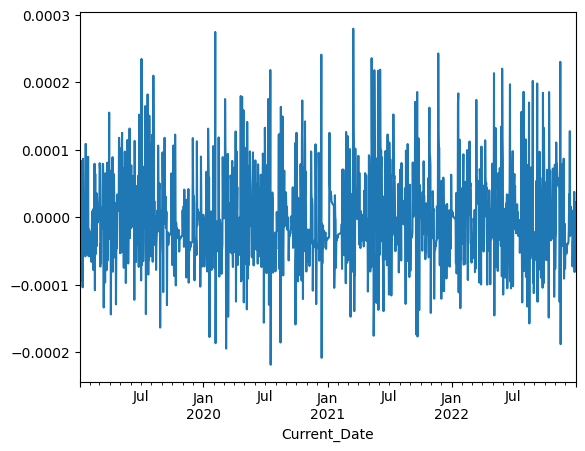

In [137]:
bibile_residuals = bibile_arima_fit.resid
bibile_residuals.plot()

Generate set of diagnostic plots to evaluate the goodness of fit and the validity of the assumptions made by the ARIMA model.

Refrences - https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMAResults.plot_diagnostics.html

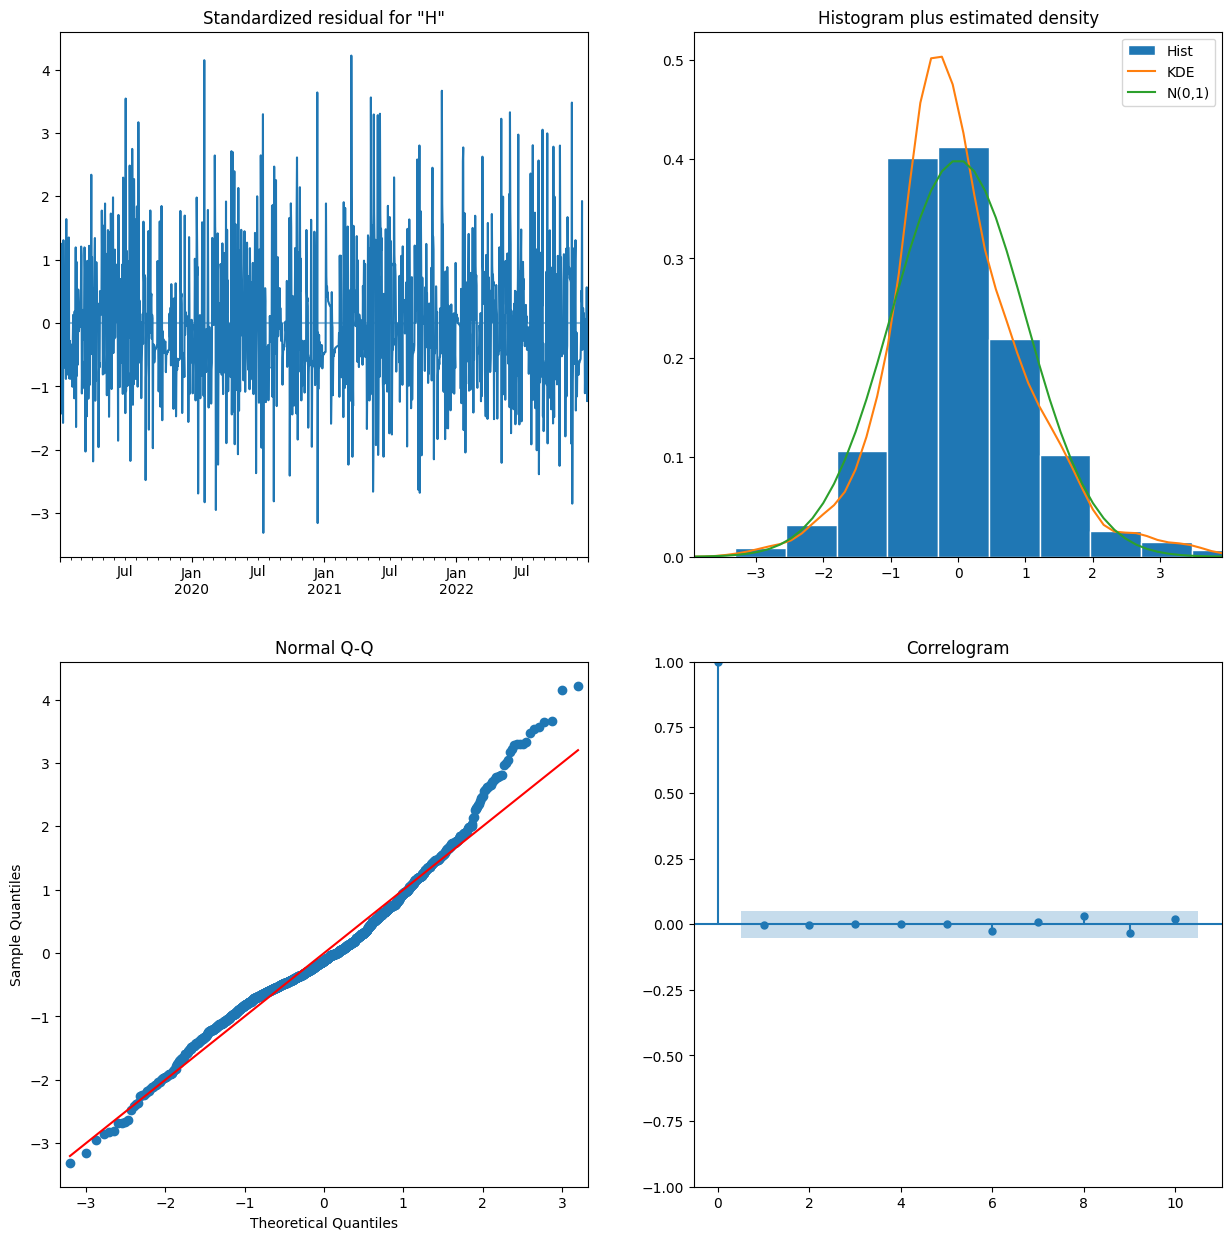

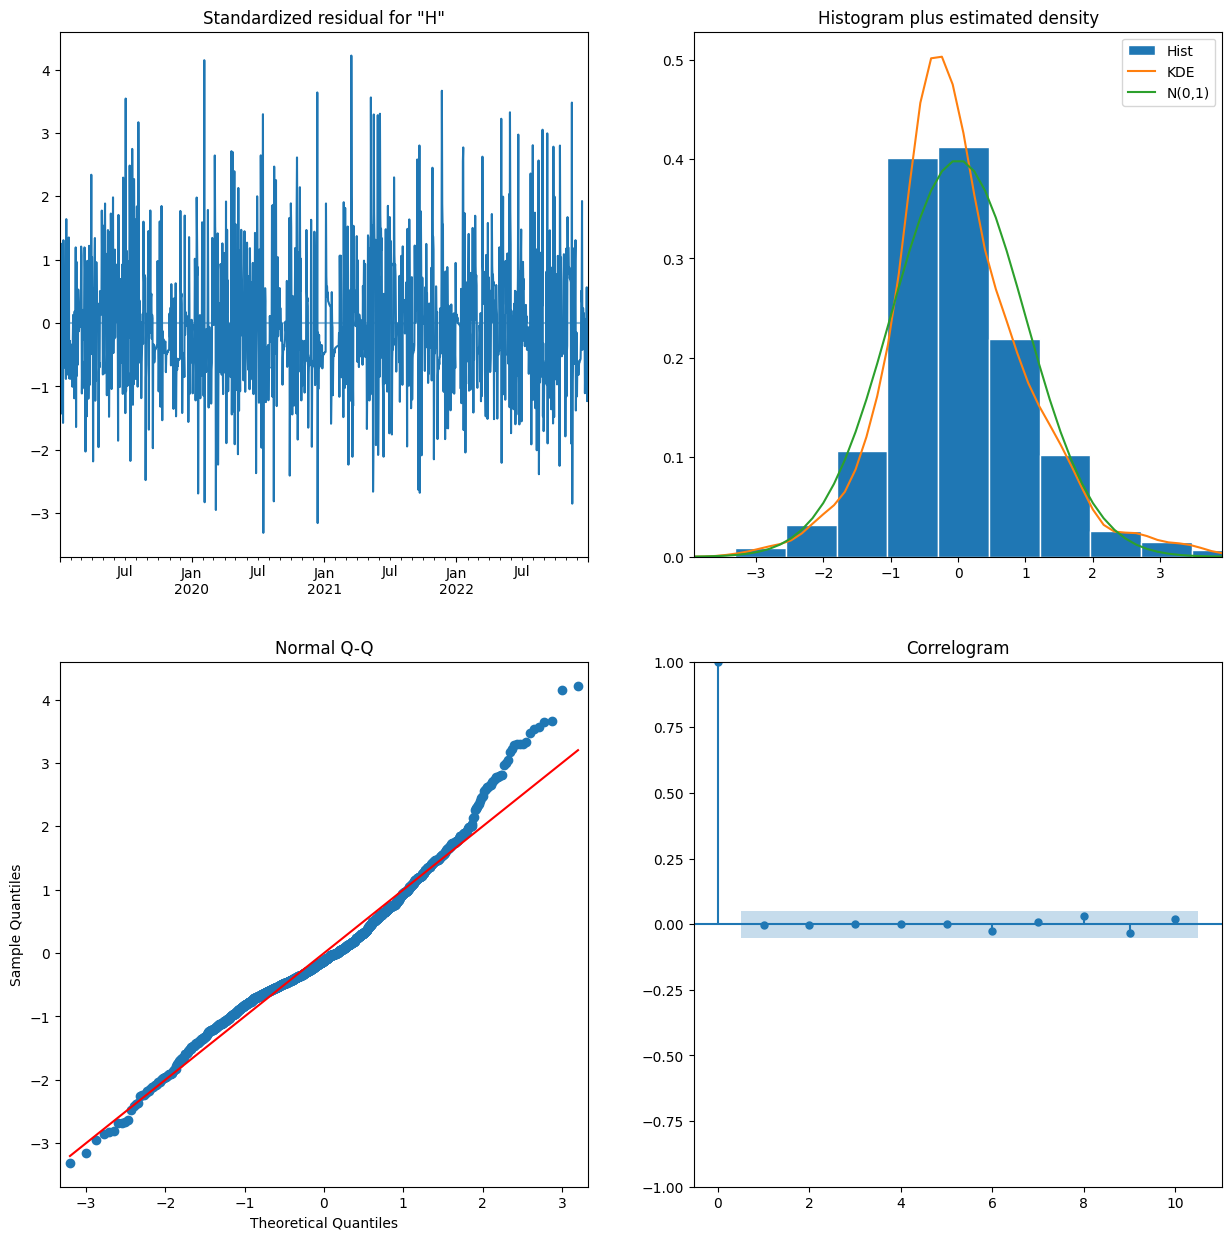

In [138]:
bibile_arima_fit.plot_diagnostics(figsize=(15,15))

In [139]:
# forecast using ARIMA model
bibile_arima_test_preds = bibile_arima_fit.forecast(steps=len(test_bibile))
print(bibile_arima_test_preds)

2023-01-01    0.000099
2023-01-02    0.000107
2023-01-03    0.000110
2023-01-04    0.000111
2023-01-05    0.000115
                ...   
2023-12-27    0.000133
2023-12-28    0.000133
2023-12-29    0.000133
2023-12-30    0.000133
2023-12-31    0.000133
Freq: D, Name: predicted_mean, Length: 365, dtype: float64


In [156]:
# MSE
bibile_arima_mse = mean_squared_error(test_bibile['HCHO_reading'], bibile_arima_test_preds)
print(f'ARIMA MSE for Bibile, Monaragala: {bibile_arima_mse}')

ARIMA MSE for Bibile, Monaragala: 6.019093242084573e-09


In [157]:
# RMSE
bibile_arima_rmse = root_mean_squared_error(test_bibile, bibile_arima_test_preds)
print(f'ARIMA RMSE for Bibile, Monaragala: {bibile_arima_rmse}')

ARIMA RMSE for Bibile, Monaragala: 7.758281537869435e-05


In [158]:
# MAE
bibile_arima_mae = mean_absolute_error(test_bibile['HCHO_reading'], bibile_arima_test_preds)
print(f'ARIMA MAE for Bibile, Monaragala: {bibile_arima_mae}')

ARIMA MAE for Bibile, Monaragala: 6.41460407677094e-05


In [160]:
forecast_steps = 365  # forecast for 365 days (1 year)
bibile_arima_forecast_next_year = bibile_arima_fit.forecast(steps=forecast_steps)

print(bibile_arima_forecast_next_year)

2023-01-01    0.000099
2023-01-02    0.000107
2023-01-03    0.000110
2023-01-04    0.000111
2023-01-05    0.000115
                ...   
2023-12-27    0.000133
2023-12-28    0.000133
2023-12-29    0.000133
2023-12-30    0.000133
2023-12-31    0.000133
Freq: D, Name: predicted_mean, Length: 365, dtype: float64


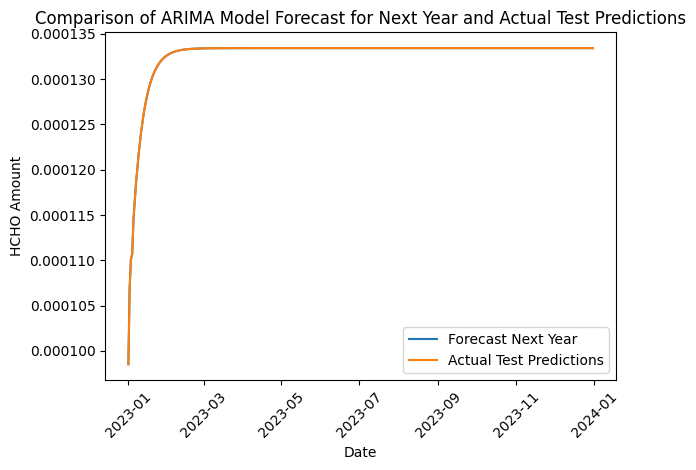

In [162]:
# forecast for the next year
plt.plot(bibile_arima_forecast_next_year.index, bibile_arima_forecast_next_year.values, label='Forecast Next Year')

# actual test predictions
plt.plot(bibile_arima_test_preds.index, bibile_arima_test_preds.values, label='Actual Test Predictions')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('HCHO Amount')
plt.title('Comparison of ARIMA Model Forecast for Next Year and Actual Test Predictions')
plt.xticks(rotation=45)  
plt.legend() 
plt.tight_layout()  
plt.show()

### SARIMA model

In [147]:
p, d, q = auto_arima_bibile.order
print(p, d, q)

4 0 5


In [150]:
# Train SARIMA model with extracted order parameters
bibile_sarima_model = SARIMAX(train_bibile, order=(p, d, q), seasonal_order=(p, d, q, 12))
bibile_sarima_fit = bibile_sarima_model.fit()

C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [151]:
print(bibile_sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       HCHO_reading   No. Observations:                 1460
Model:             SARIMAX(4, 0, 5)x(4, 0, 5, 12)   Log Likelihood               11901.706
Date:                            Sat, 20 Apr 2024   AIC                         -23765.412
Time:                                    18:45:41   BIC                         -23664.974
Sample:                                01-02-2019   HQIC                        -23727.945
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5000   1.44e-05   3.48e+04      0.000       0.500       0.500
ar.L2          0.2101   7.41e-05   

<Axes: xlabel='Current_Date'>

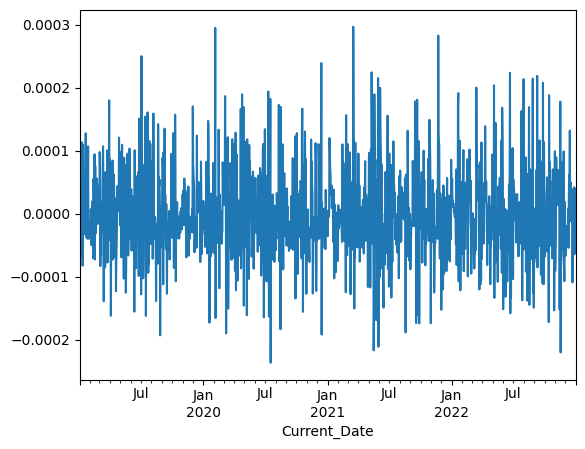

In [152]:
# SARIMA model diagnostics
bibile_sarima_residuals = bibile_sarima_fit.resid
bibile_sarima_residuals.plot()

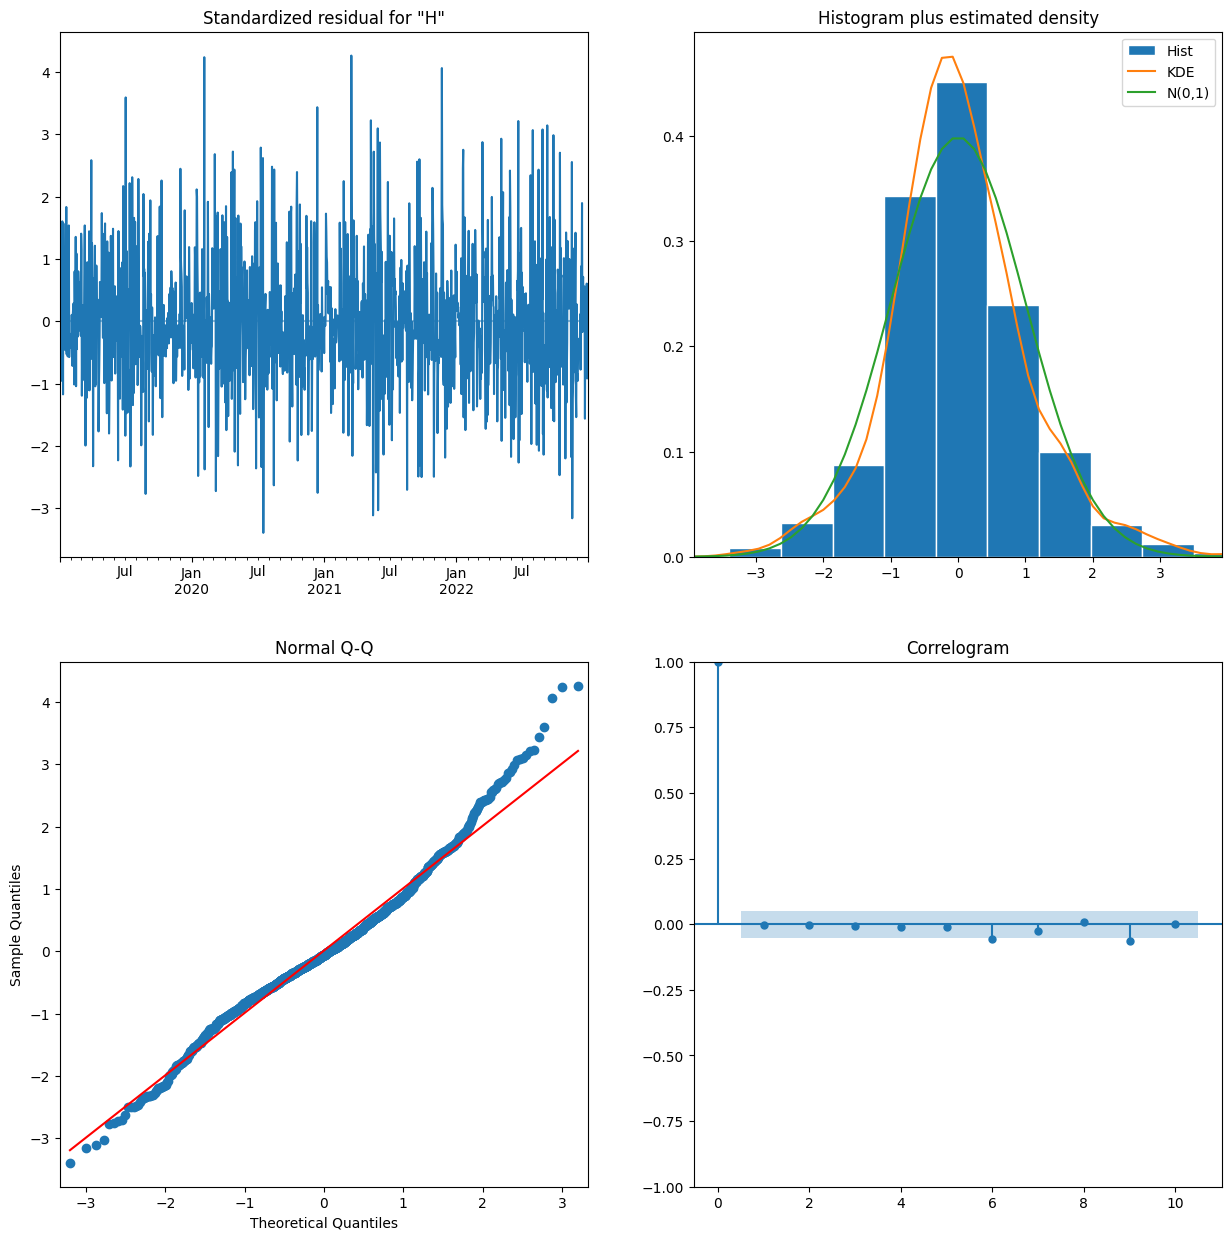

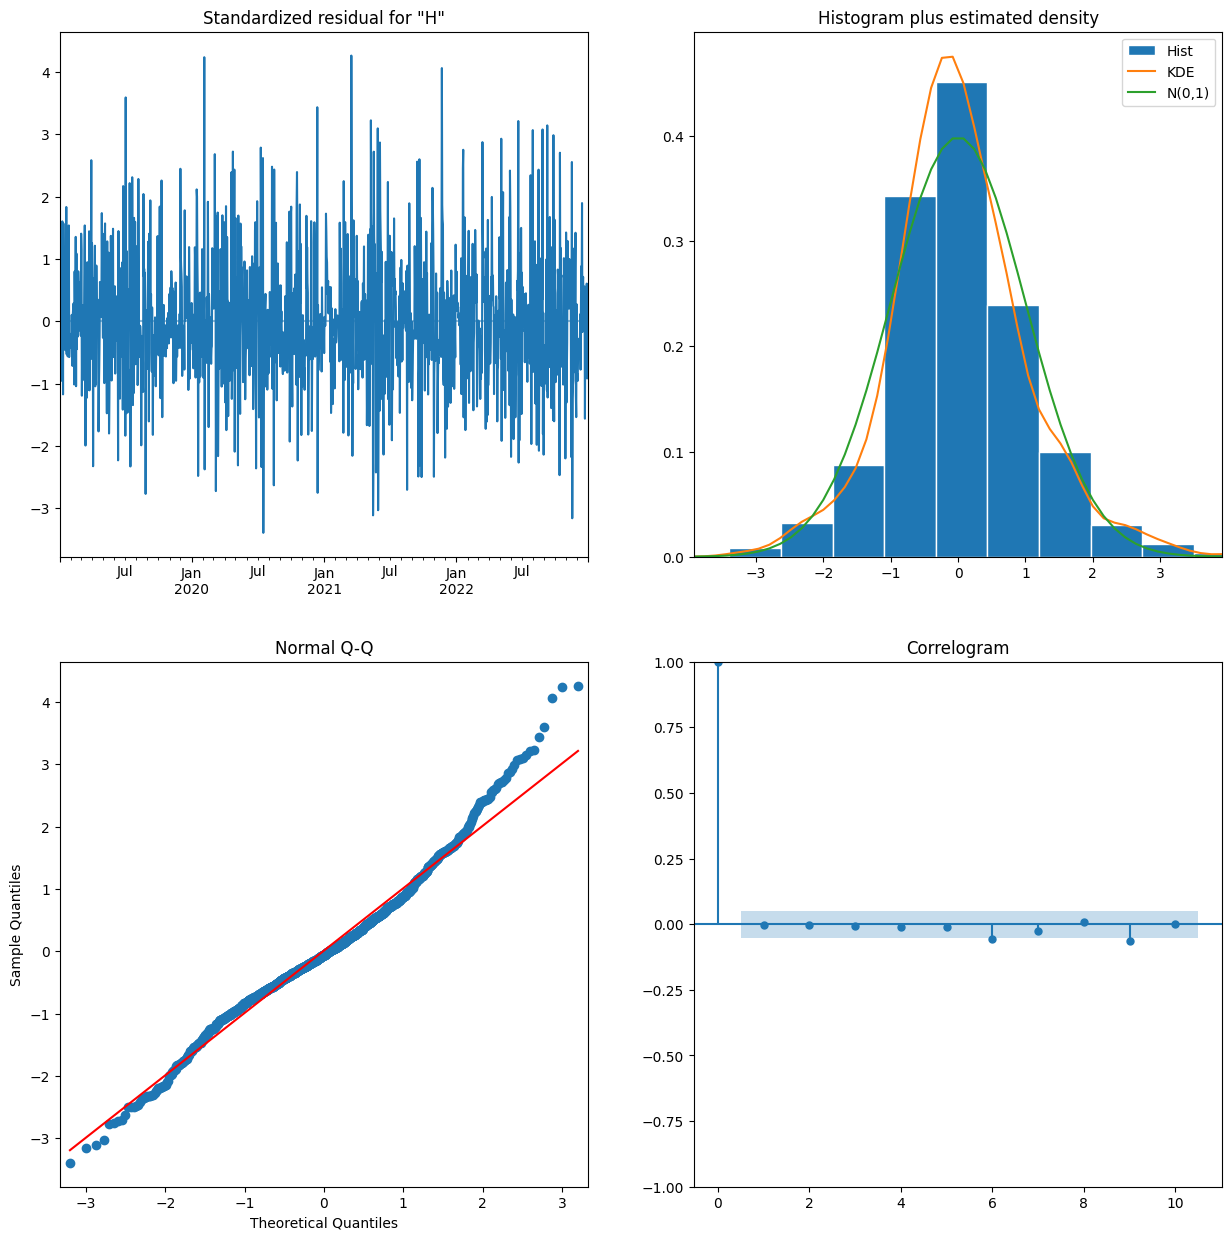

In [153]:
bibile_sarima_fit.plot_diagnostics(figsize=(15, 15))

In [154]:
# Forecast using SARIMA model
bibile_sarima_test_preds = bibile_sarima_fit.forecast(steps=len(test_bibile))
print(bibile_sarima_test_preds)

2023-01-01    0.000080
2023-01-02    0.000061
2023-01-03    0.000097
2023-01-04    0.000059
2023-01-05    0.000062
                ...   
2023-12-27    0.000040
2023-12-28    0.000029
2023-12-29    0.000044
2023-12-30    0.000030
2023-12-31    0.000033
Freq: D, Name: predicted_mean, Length: 365, dtype: float64


In [155]:
# Calculate MSE
bibile_sarima_mse = mean_squared_error(test_bibile, bibile_sarima_test_preds)
print(f'SARIMA MSE for Bibile, Monaragala: {bibile_sarima_mse}')

SARIMA MSE for Bibile, Monaragala: 1.2618565310138952e-08


In [164]:
# Calculate RMSE
bibile_sarima_rmse = root_mean_squared_error(test_bibile, bibile_sarima_test_preds)
print(f'SARIMA RMSE for Bibile, Monaragala: {bibile_sarima_rmse}')

SARIMA RMSE for Bibile, Monaragala: 0.00011233238762769601


In [165]:
# Calculate MAE
bibile_sarima_mae = mean_absolute_error(test_bibile, bibile_sarima_test_preds)
print(f'SARIMA MAE for Bibile, Monaragala: {bibile_sarima_mae}')

SARIMA MAE for Bibile, Monaragala: 8.905117250412734e-05


In [166]:
# Forecast for next year (365 days)
forecast_steps = 365
bibile_sarima_forecast_next_year = bibile_sarima_fit.forecast(steps=forecast_steps)
print(bibile_sarima_forecast_next_year)

2023-01-01    0.000080
2023-01-02    0.000061
2023-01-03    0.000097
2023-01-04    0.000059
2023-01-05    0.000062
                ...   
2023-12-27    0.000040
2023-12-28    0.000029
2023-12-29    0.000044
2023-12-30    0.000030
2023-12-31    0.000033
Freq: D, Name: predicted_mean, Length: 365, dtype: float64


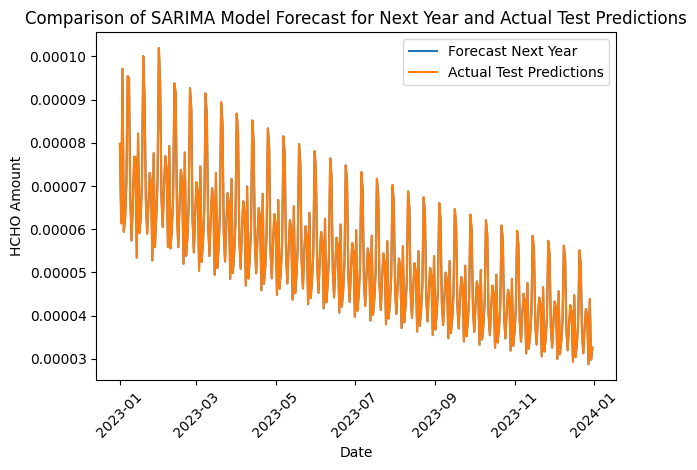

In [167]:
# forecast for the next year
plt.plot(bibile_sarima_forecast_next_year.index, bibile_sarima_forecast_next_year.values, label='Forecast Next Year')

# actual test predictions
plt.plot(bibile_sarima_test_preds.index, bibile_sarima_test_preds.values, label='Actual Test Predictions')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('HCHO Amount')
plt.title('Comparison of SARIMA Model Forecast for Next Year and Actual Test Predictions')
plt.xticks(rotation=45)  
plt.legend() 
plt.tight_layout()  
plt.show()

### Done ARIMA & SARIMA models for Bibile, Monaragala city.

## Train model same as for other 6 cities using a loop

In [168]:
# data of all cities
dataframes = {
    'Colombo': colombo_df,
    'Deniyaya': deniyaya_df,
    'Jaffna': jaffna_df,
    'Kandy': kandy_df,
    'Kurunegala': kurunegala_df,
    'Nuwara Eliya': nuwara_eliya_df
}

## ARIMA Models for each cities


Processing data for Colombo
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-23629.506, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23211.088, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-23416.518, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-23547.741, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-23213.078, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-23609.365, Time=1.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-23614.136, Time=4.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-23630.149, Time=0.99 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-23559.713, Time=0.79 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-23617.983, Time=1.42 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-23634.992, Time=1.37 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-23196.941, Time=0.93 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-23637.722, Time=1.33 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=-2

C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCac

                               SARIMAX Results                                
Dep. Variable:           HCHO_reading   No. Observations:                 1460
Model:                 ARIMA(4, 1, 3)   Log Likelihood               11822.316
Date:                Sat, 20 Apr 2024   AIC                         -23628.633
Time:                        19:36:09   BIC                         -23586.349
Sample:                    01-02-2019   HQIC                        -23612.858
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3724      0.001  -1188.358      0.000      -1.375      -1.370
ar.L2         -0.2098      0.001   -172.349      0.000      -0.212      -0.207
ar.L3          0.1734      0.001    144.781      0.0

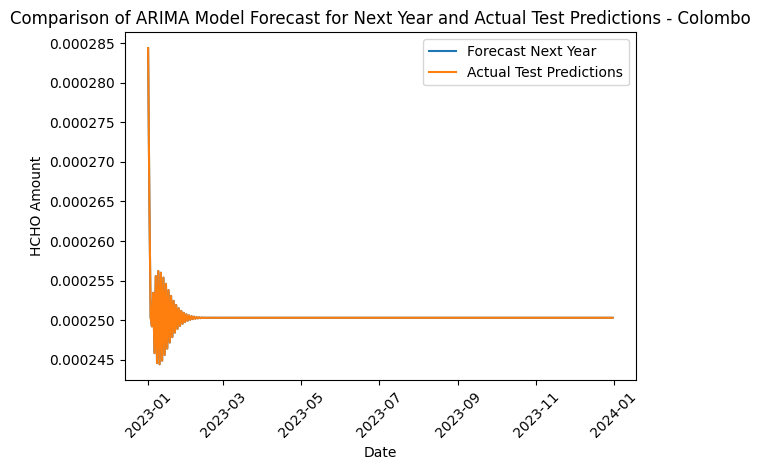


Processing data for Deniyaya
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-21929.593, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-21937.610, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-24050.239, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-22960.561, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-24088.850, Time=0.30 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-24101.972, Time=0.38 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-24124.398, Time=0.46 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-24143.872, Time=0.62 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-24143.390, Time=0.72 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-24111.682, Time=0.54 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-24268.843, Time=0.43 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-24267.092, Time=0.36 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=-24259.973, Time=0.47 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-

C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCac

                               SARIMAX Results                                
Dep. Variable:           HCHO_reading   No. Observations:                 1460
Model:                 ARIMA(5, 0, 0)   Log Likelihood               12141.421
Date:                Sat, 20 Apr 2024   AIC                         -24268.843
Time:                        19:36:15   BIC                         -24231.839
Sample:                    01-01-2019   HQIC                        -24255.039
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   4.55e-06     23.902      0.000    9.98e-05       0.000
ar.L1          0.5996   5.57e-10   1.08e+09      0.000       0.600       0.600
ar.L2          0.0319   3.17e-10   1.01e+08      0.0

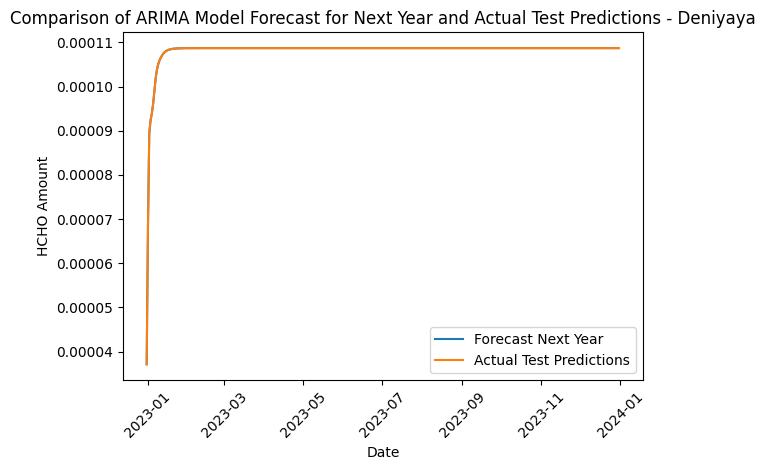


Processing data for Jaffna
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-24145.596, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-21977.369, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-23865.243, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-22832.995, Time=0.26 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-24148.825, Time=0.24 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-23138.561, Time=0.33 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-24089.819, Time=0.29 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-24140.961, Time=0.57 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-23263.357, Time=0.47 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-24124.838, Time=0.33 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-24185.344, Time=0.49 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-24183.045, Time=0.71 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-21965.370, Time=0.53 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-24

C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCac

                               SARIMAX Results                                
Dep. Variable:           HCHO_reading   No. Observations:                 1460
Model:                 ARIMA(3, 0, 4)   Log Likelihood               12145.230
Date:                Sat, 20 Apr 2024   AIC                         -24272.460
Time:                        19:36:41   BIC                         -24224.884
Sample:                    01-01-2019   HQIC                        -24254.712
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   4.47e-06     25.094      0.000       0.000       0.000
ar.L1         -0.2502   2.88e-10   -8.7e+08      0.000      -0.250      -0.250
ar.L2          0.6616   2.23e-10   2.96e+09      0.0

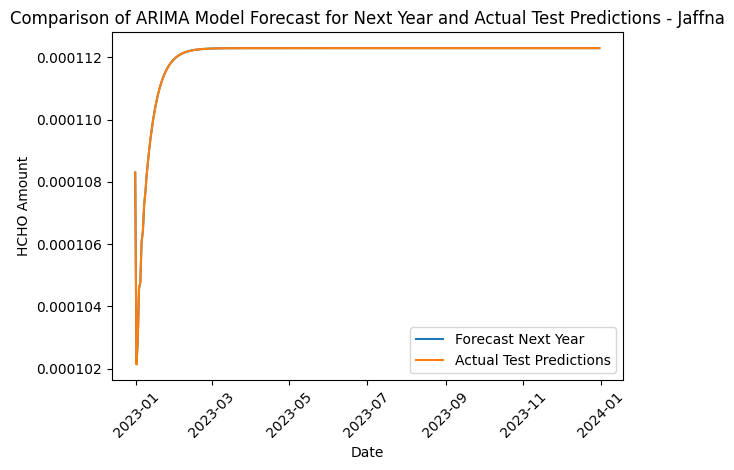


Processing data for Kandy
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-24215.971, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-21817.838, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-24088.080, Time=0.24 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-22834.197, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-24218.791, Time=0.32 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-23263.213, Time=0.32 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-24204.730, Time=0.30 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-24223.972, Time=0.62 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-23524.351, Time=0.41 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-24226.892, Time=0.70 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-21805.838, Time=0.89 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-24230.915, Time=0.88 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-24231.098, Time=0.70 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=-236

C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCac

                               SARIMAX Results                                
Dep. Variable:           HCHO_reading   No. Observations:                 1460
Model:                 ARIMA(1, 0, 3)   Log Likelihood               12175.571
Date:                Sat, 20 Apr 2024   AIC                         -24339.142
Time:                        19:37:06   BIC                         -24307.425
Sample:                    01-02-2019   HQIC                        -24327.311
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   4.55e-06     25.576      0.000       0.000       0.000
ar.L1          0.7037   4.91e-10   1.43e+09      0.000       0.704       0.704
ma.L1         -0.1705   2.49e-10  -6.86e+08      0.0

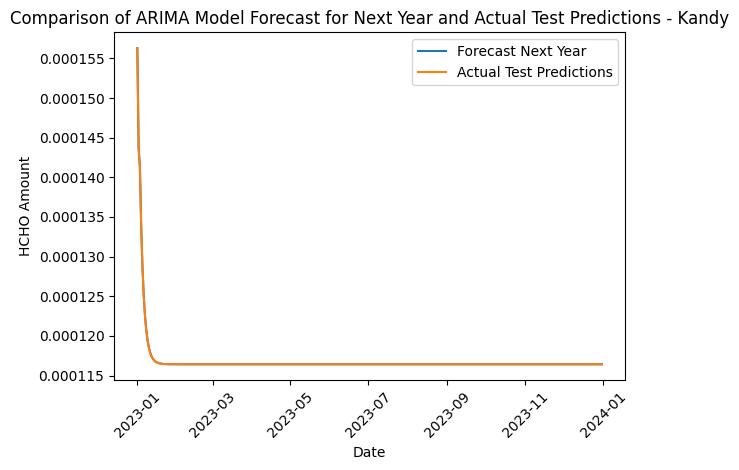


Processing data for Kurunegala
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-23986.831, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-21438.095, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-23718.897, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-22410.564, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-23985.036, Time=0.46 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-23965.990, Time=0.43 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-23980.438, Time=0.59 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-24010.014, Time=0.62 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-23994.763, Time=0.53 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-24005.433, Time=0.72 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-24029.487, Time=0.67 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-23991.077, Time=0.63 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=-24023.551, Time=0.82 sec
 ARIMA(2,0,5)(0,0,0)[0]             : AIC

C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCac

                               SARIMAX Results                                
Dep. Variable:           HCHO_reading   No. Observations:                 1460
Model:                 ARIMA(3, 0, 4)   Log Likelihood               12048.589
Date:                Sat, 20 Apr 2024   AIC                         -24079.179
Time:                        19:37:29   BIC                         -24031.603
Sample:                    01-01-2019   HQIC                        -24061.431
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   6.64e-06     20.626      0.000       0.000       0.000
ar.L1          0.2391   8.67e-10   2.76e+08      0.000       0.239       0.239
ar.L2          0.2675   6.02e-10   4.45e+08      0.0

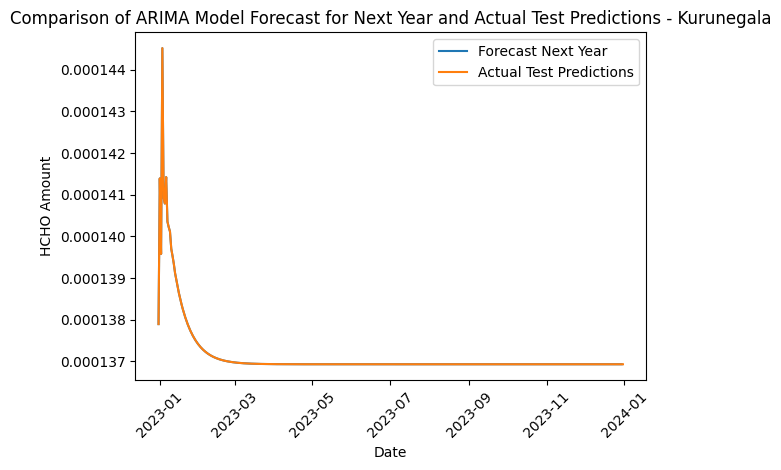


Processing data for Nuwara Eliya
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-24540.000, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-22025.198, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-24455.695, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-23144.130, Time=0.24 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-24519.970, Time=0.45 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-24529.618, Time=0.43 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-22015.185, Time=0.68 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-24533.853, Time=0.75 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-24500.107, Time=0.30 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-24534.325, Time=0.56 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-24494.434, Time=0.47 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-22013.185, Time=0.83 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-24627.775, Time=0.98 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : A

C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCac

                               SARIMAX Results                                
Dep. Variable:           HCHO_reading   No. Observations:                 1460
Model:                 ARIMA(2, 0, 0)   Log Likelihood               12320.660
Date:                Sat, 20 Apr 2024   AIC                         -24633.319
Time:                        19:37:41   BIC                         -24612.175
Sample:                    01-01-2019   HQIC                        -24625.432
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   4.61e-06     23.008      0.000    9.71e-05       0.000
ar.L1          0.6504   5.26e-10   1.24e+09      0.000       0.650       0.650
ar.L2          0.0485   2.86e-10    1.7e+08      0.0

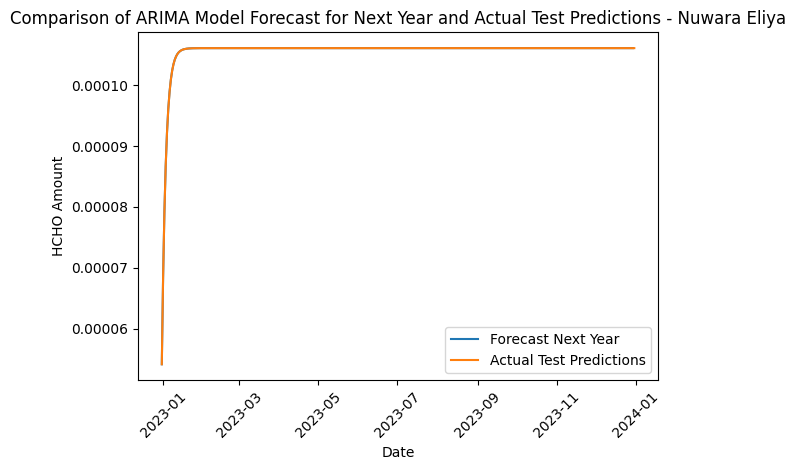

In [169]:
# Loop through each city
for city, df in dataframes.items():
    print(f"\nProcessing data for {city}")

    # convert 'Current_Date' dtype to datetime
    df['Current_Date'] = pd.to_datetime(df['Current_Date'])
    # drop unnecessary columns
    df = df.drop(['Location', 'Next_Date'], axis=1)
    # det 'Current_Date' as index
    df.set_index('Current_Date', inplace=True)
    # dplit data into training and testing sets
    train_size = 0.8
    train_data, test_data = train_test_split(df, train_size=train_size, shuffle=False)

    # fit auto-ARIMA model
    auto_arima_model = auto_arima(train_data, seasonal=False, trace=True)
    p, d, q = auto_arima_model.order
    print(f"Auto-ARIMA Order for {city}: {p}, {d}, {q}")
    
    # train ARIMA model
    arima_model = ARIMA(train_data, order=(p, d, q))
    arima_fit = arima_model.fit()
    print(arima_fit.summary())
    
    # forecast using ARIMA model
    arima_test_preds = arima_fit.forecast(steps=len(test_data))
    print(arima_test_preds)
    
    # calculate MSE, RMSE, MAE
    mse = mean_squared_error(test_data['HCHO_reading'], arima_test_preds)
    rmse = mean_squared_error(test_data['HCHO_reading'], arima_test_preds, squared=False)
    mae = mean_absolute_error(test_data['HCHO_reading'], arima_test_preds)
    print(f'ARIMA MSE for {city}: {mse}')
    print(f'ARIMA RMSE for {city}: {rmse}')
    print(f'ARIMA MAE for {city}: {mae}')
    
    # forecast for next year
    forecast_steps = 365
    arima_forecast_next_year = arima_fit.forecast(steps=forecast_steps)
    print(arima_forecast_next_year)
    
    # plot forecast and actual test predictions
    plt.plot(arima_forecast_next_year.index, arima_forecast_next_year.values, label='Forecast Next Year')
    plt.plot(arima_test_preds.index, arima_test_preds.values, label='Actual Test Predictions')
    plt.xlabel('Date')
    plt.ylabel('HCHO Amount')
    plt.title(f'Comparison of ARIMA Model Forecast for Next Year and Actual Test Predictions - {city}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

## SARIMA Models for each cities


Processing data for Colombo
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-23629.506, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23211.088, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-23416.518, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-23547.741, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-23213.078, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-23609.365, Time=1.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-23614.136, Time=4.38 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-23630.149, Time=1.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-23559.713, Time=0.85 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-23617.983, Time=1.38 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-23634.992, Time=1.39 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-23196.941, Time=0.97 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-23637.722, Time=1.37 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=-2

C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\benur\AppData\Local\Packages\PythonSoftwar

                                     SARIMAX Results                                      
Dep. Variable:                       HCHO_reading   No. Observations:                 1460
Model:             SARIMAX(4, 1, 3)x(4, 1, 3, 12)   Log Likelihood               11396.528
Date:                            Sat, 20 Apr 2024   AIC                         -22763.057
Time:                                    19:48:12   BIC                         -22683.898
Sample:                                01-02-2019   HQIC                        -22733.514
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1              -0   2.91e-18         -0      1.000    -5.7e-18     5.7e-18
ar.L2              -0   1.06e-19   

C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


SARIMA RMSE for Colombo: 0.0009895780178581393
SARIMA MAE for Colombo: 0.0008960631333585376
2023-01-01    0.000388
2023-01-02    0.000429
2023-01-03    0.000412
2023-01-04    0.000402
2023-01-05    0.000394
                ...   
2023-12-27    0.001716
2023-12-28    0.001748
2023-12-29    0.001725
2023-12-30    0.001733
2023-12-31    0.001715
Freq: D, Name: predicted_mean, Length: 365, dtype: float64


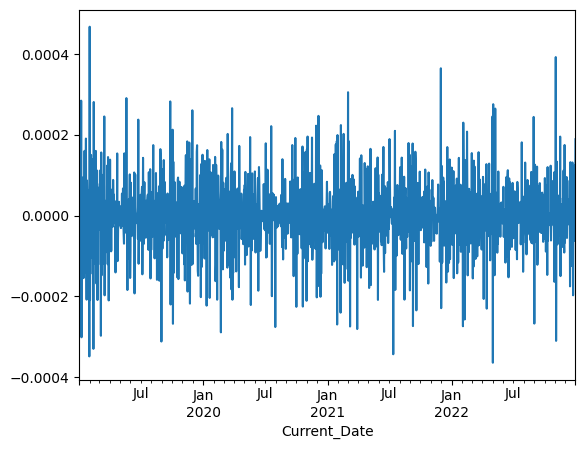

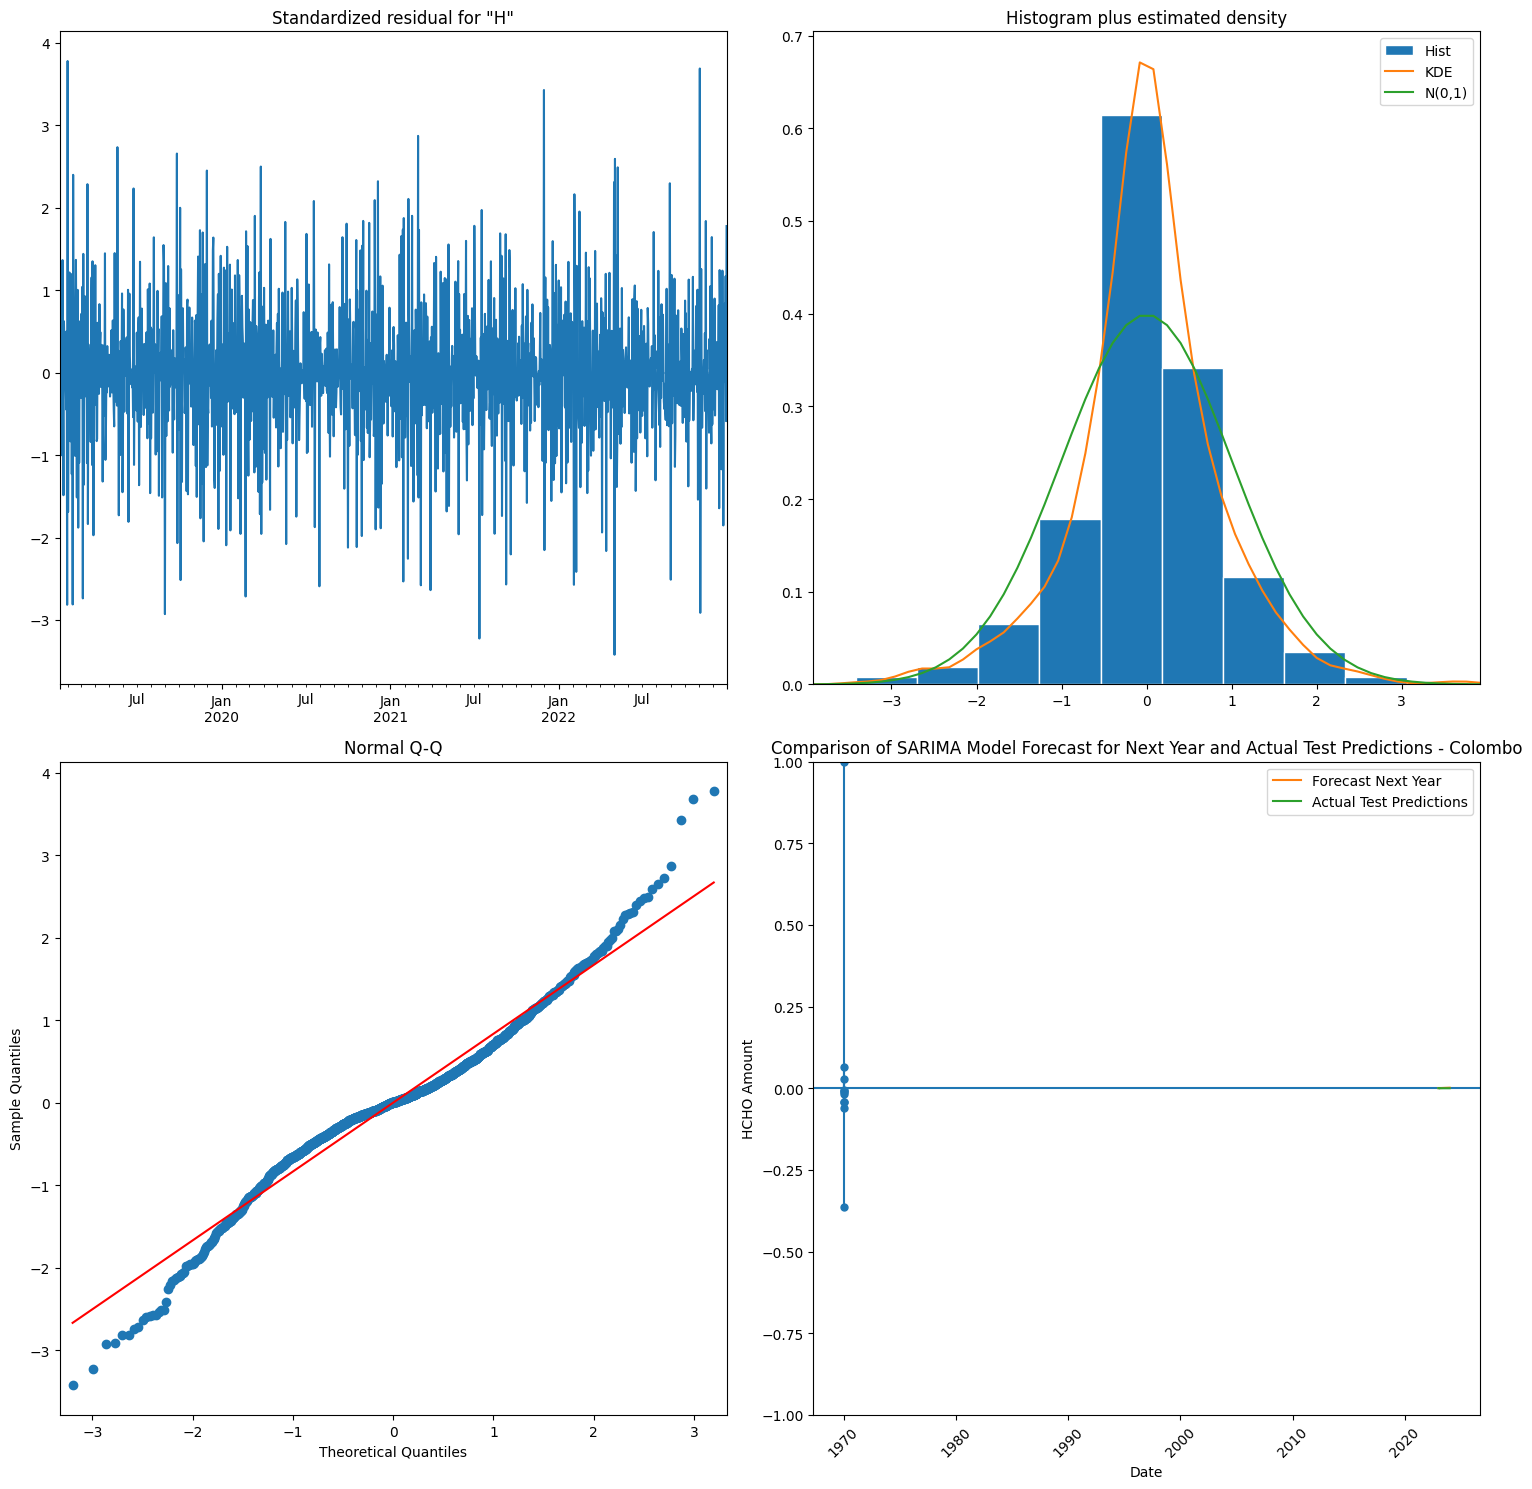


Processing data for Deniyaya
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-21929.593, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-21937.610, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-24050.239, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-22960.561, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-24088.850, Time=0.32 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-24101.972, Time=0.38 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-24124.398, Time=0.51 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-24143.872, Time=0.65 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-24143.390, Time=0.76 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-24111.682, Time=0.60 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-24268.843, Time=0.43 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-24267.092, Time=0.35 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=-24259.973, Time=0.50 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-

C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                       HCHO_reading   No. Observations:                 1460
Model:             SARIMAX(5, 0, 0)x(5, 0, 0, 12)   Log Likelihood               11969.439
Date:                            Sat, 20 Apr 2024   AIC                         -23916.877
Time:                                    19:48:28   BIC                         -23858.729
Sample:                                01-01-2019   HQIC                        -23895.186
                                     - 12-30-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6856   3.49e-19   1.97e+18      0.000       0.686       0.686
ar.L2          0.0695   2.68e-19   

C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2022-12-31    0.000043
2023-01-01    0.000020
2023-01-02    0.000041
2023-01-03    0.000031
2023-01-04    0.000028
                ...   
2023-12-26    0.000014
2023-12-27    0.000009
2023-12-28    0.000012
2023-12-29    0.000011
2023-12-30    0.000010
Freq: D, Name: predicted_mean, Length: 365, dtype: float64


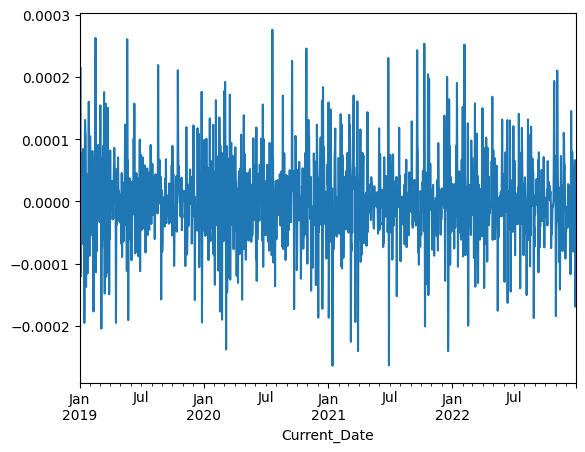

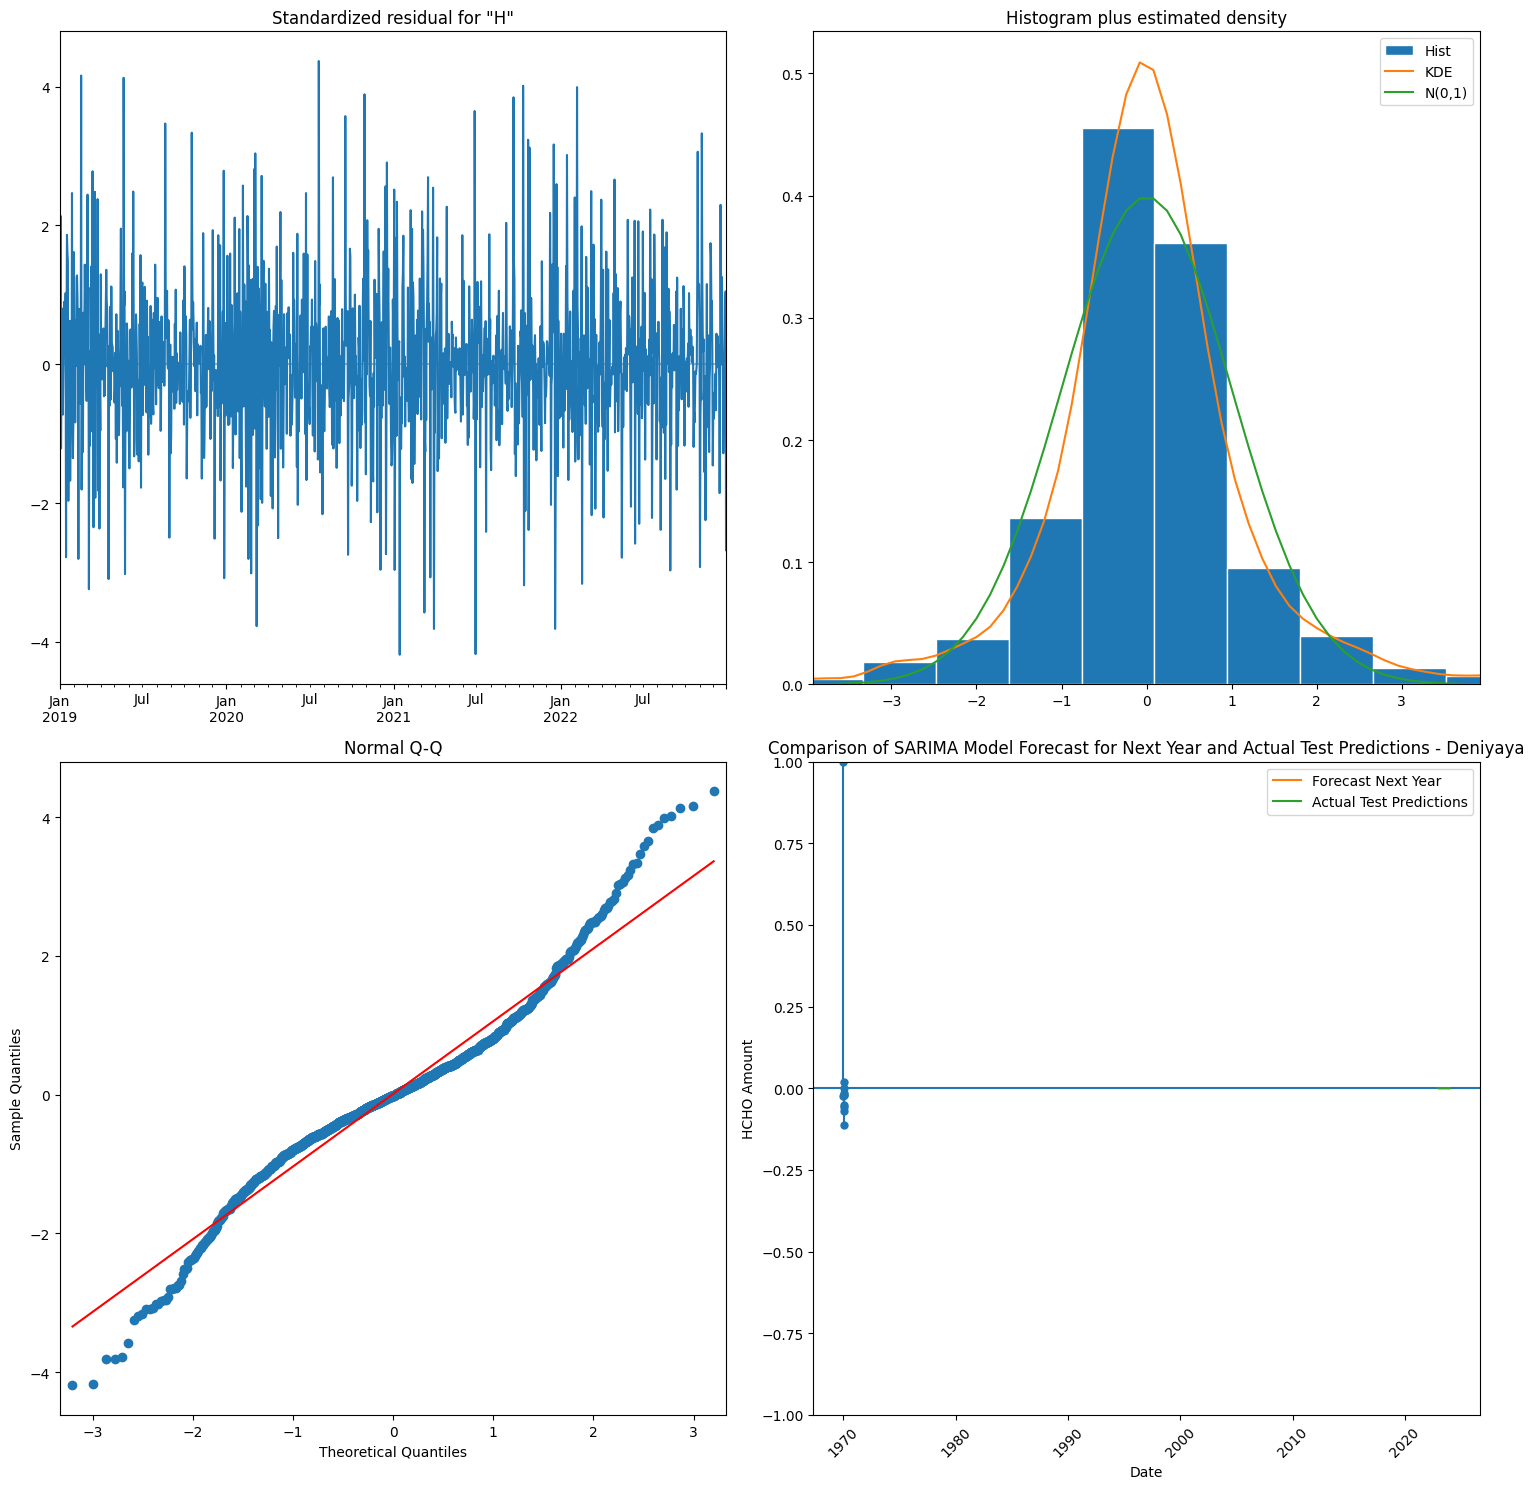


Processing data for Jaffna
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-24145.596, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-21977.369, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-23865.243, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-22832.995, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-24148.825, Time=0.25 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-23138.561, Time=0.37 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-24089.819, Time=0.30 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-24140.961, Time=0.58 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-23263.357, Time=0.48 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-24124.838, Time=0.38 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-24185.344, Time=0.53 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-24183.045, Time=0.75 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-21965.370, Time=0.60 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-24

C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                       HCHO_reading   No. Observations:                 1460
Model:             SARIMAX(3, 0, 4)x(3, 0, 4, 12)   Log Likelihood               12090.076
Date:                            Sat, 20 Apr 2024   AIC                         -24150.153
Time:                                    19:49:13   BIC                         -24070.860
Sample:                                01-01-2019   HQIC                        -24120.573
                                     - 12-30-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1566   9.69e-05  -1615.785      0.000      -0.157      -0.156
ar.L2          0.8047    7.2e-05   

C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


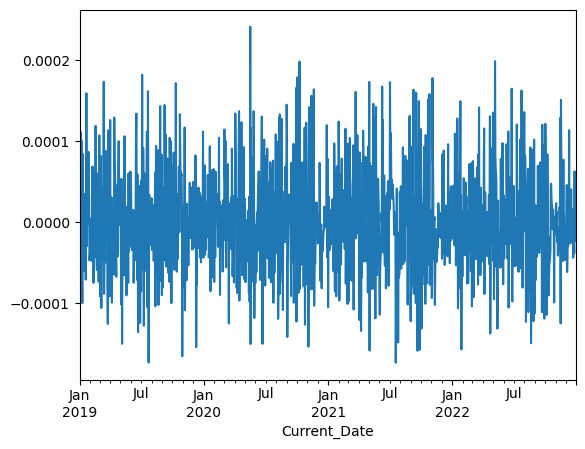

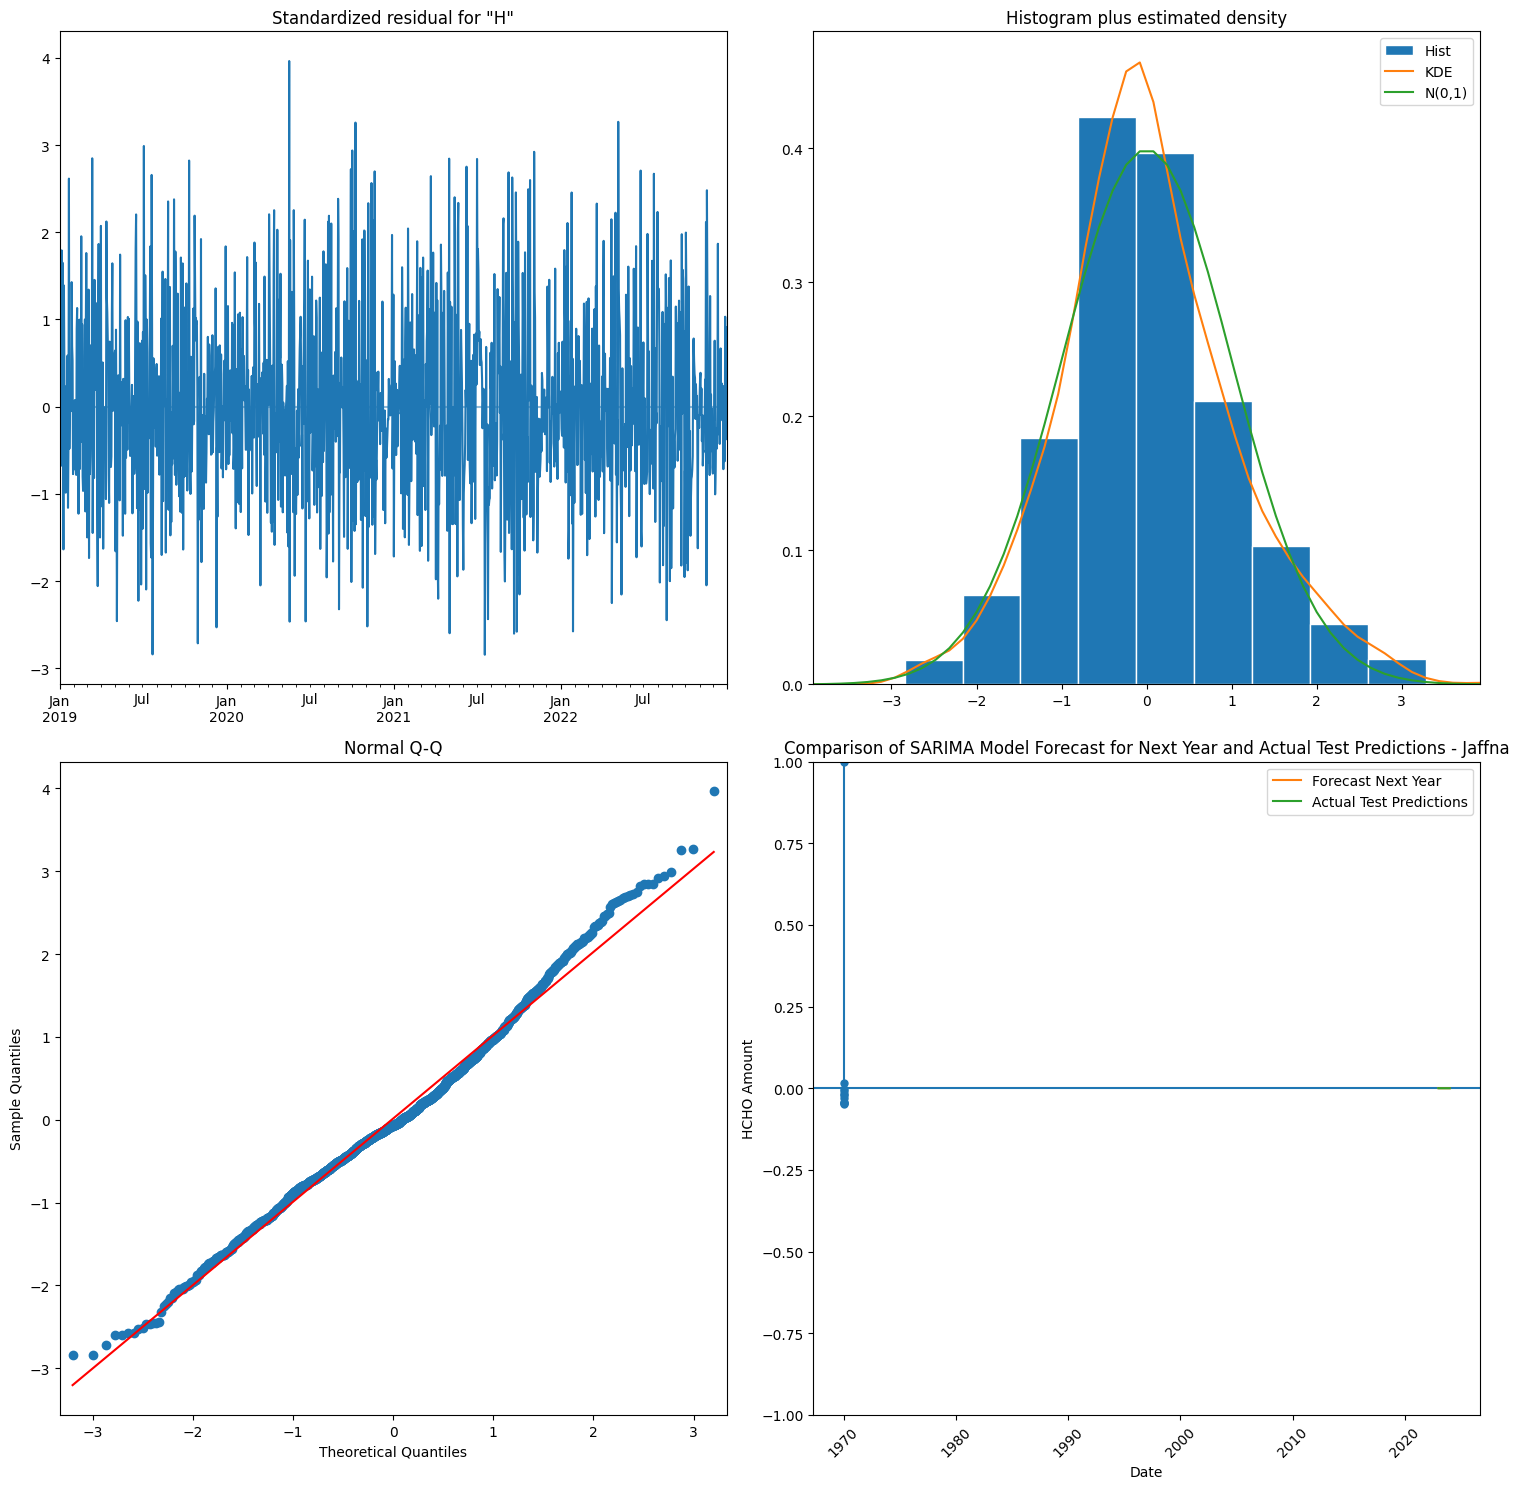


Processing data for Kandy
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-24215.971, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-21817.838, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-24088.080, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-22834.197, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-24218.791, Time=0.30 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-23263.213, Time=0.32 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-24204.730, Time=0.30 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-24223.972, Time=0.60 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-23524.351, Time=0.42 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-24226.892, Time=0.70 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-21805.838, Time=0.90 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-24230.915, Time=0.73 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-24231.098, Time=0.63 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=-236

C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                       HCHO_reading   No. Observations:                 1460
Model:             SARIMAX(1, 0, 3)x(1, 0, 3, 12)   Log Likelihood               12117.095
Date:                            Sat, 20 Apr 2024   AIC                         -24216.191
Time:                                    19:49:40   BIC                         -24168.615
Sample:                                01-02-2019   HQIC                        -24198.443
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9765   2.49e-19   3.92e+18      0.000       0.976       0.976
ma.L1         -0.3767   2.51e-19   

C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


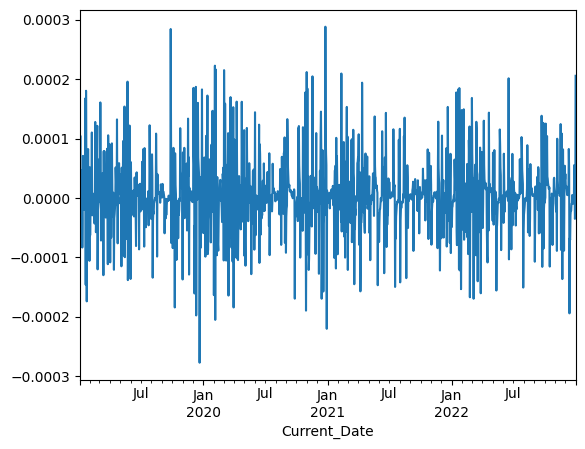

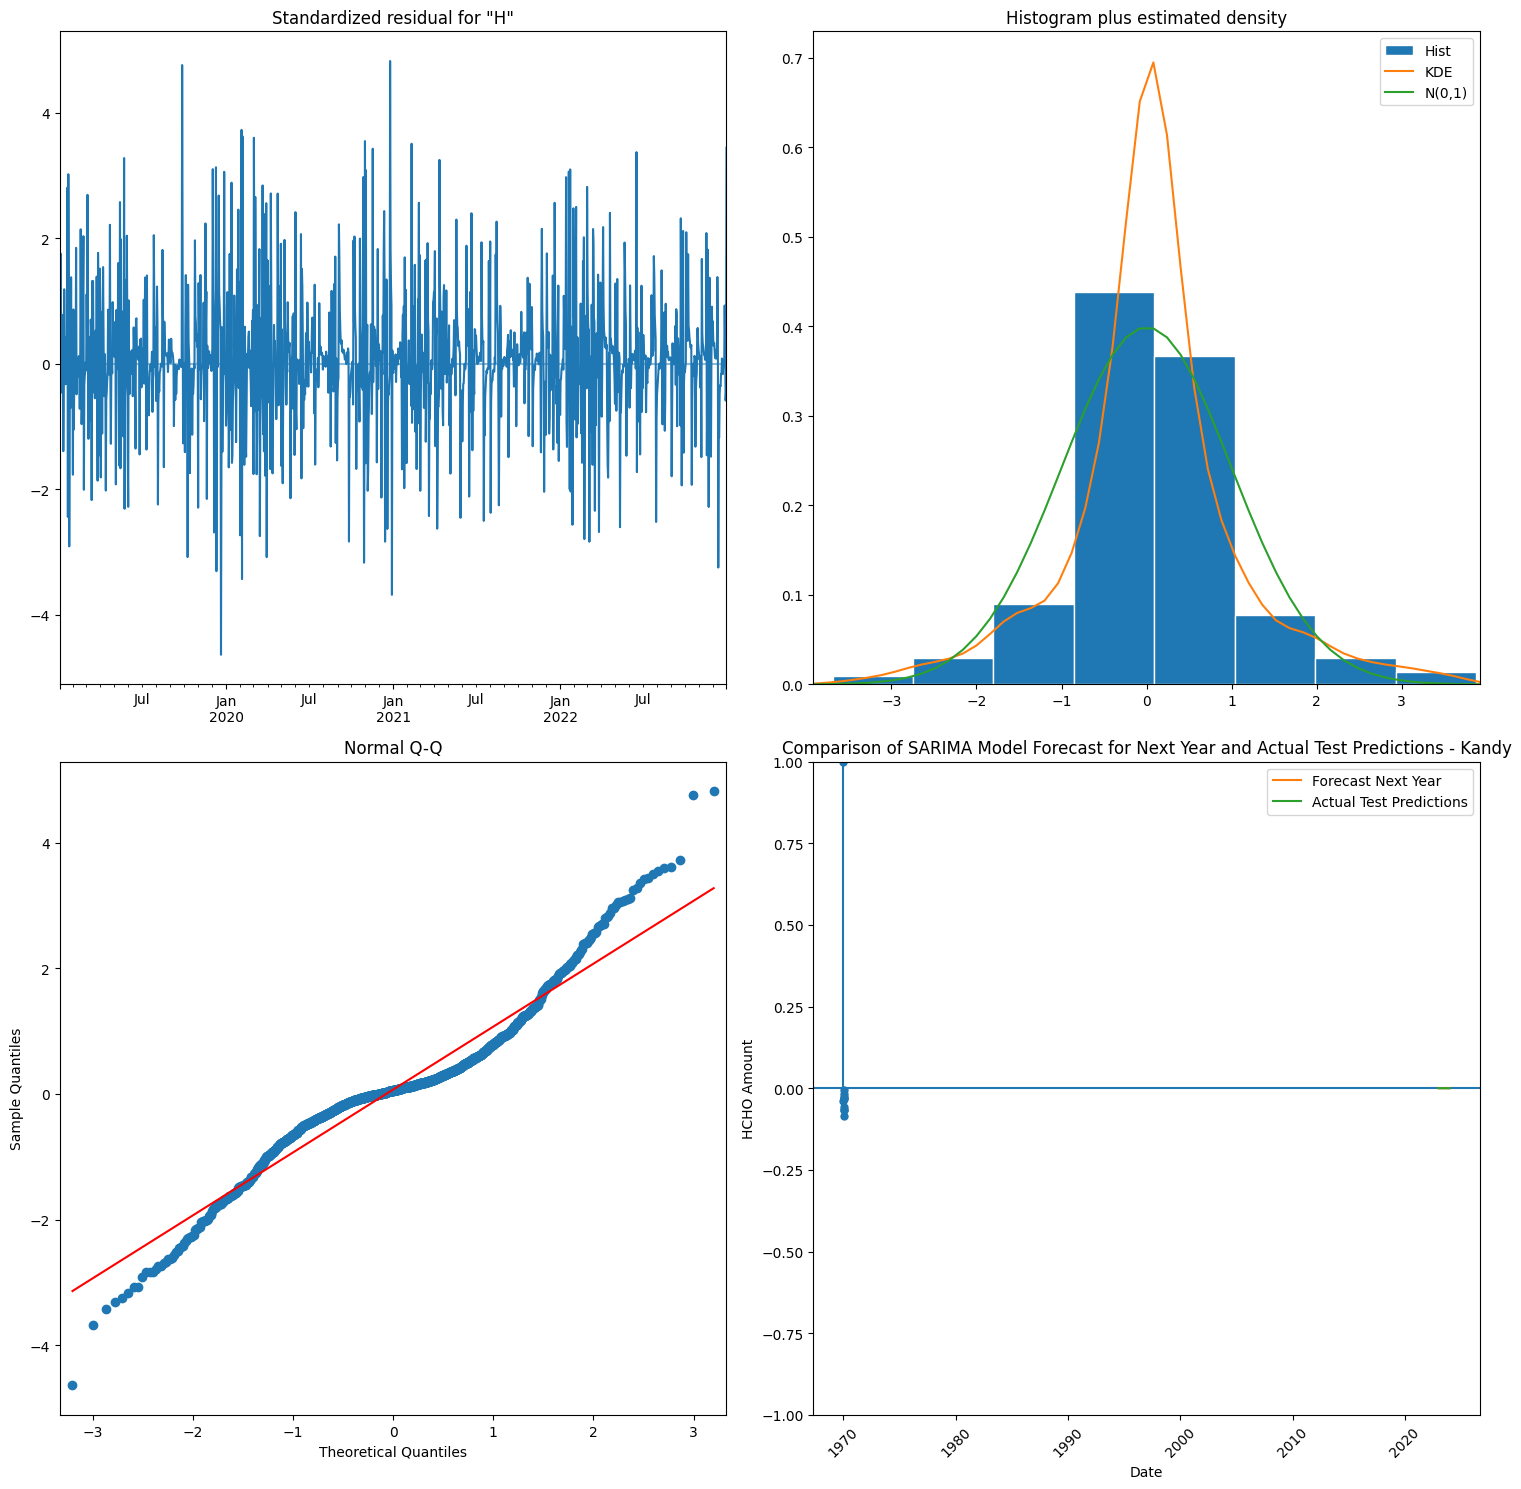


Processing data for Kurunegala
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-23986.831, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-21438.095, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-23718.897, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-22410.564, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-23985.036, Time=0.42 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-23965.990, Time=0.38 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-23980.438, Time=0.57 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-24010.014, Time=0.59 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-23994.763, Time=0.49 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-24005.433, Time=0.69 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-24029.487, Time=0.63 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-23991.077, Time=0.63 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=-24023.551, Time=0.79 sec
 ARIMA(2,0,5)(0,0,0)[0]             : AIC

C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                       HCHO_reading   No. Observations:                 1460
Model:             SARIMAX(3, 0, 4)x(3, 0, 4, 12)   Log Likelihood               11979.924
Date:                            Sat, 20 Apr 2024   AIC                         -23929.848
Time:                                    19:50:27   BIC                         -23850.555
Sample:                                01-01-2019   HQIC                        -23900.269
                                     - 12-30-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2476   8.11e-05   3053.722      0.000       0.247       0.248
ar.L2          0.2786   5.28e-05   

C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


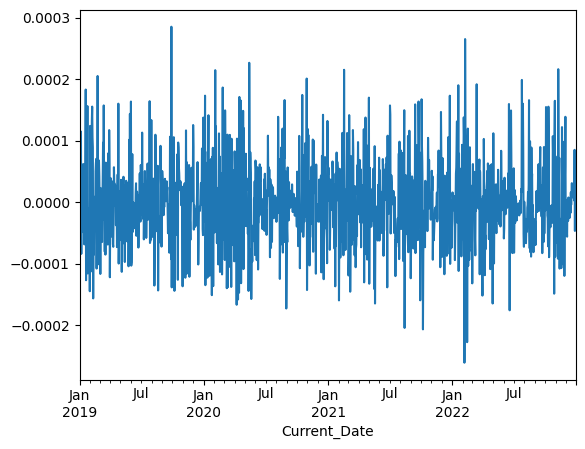

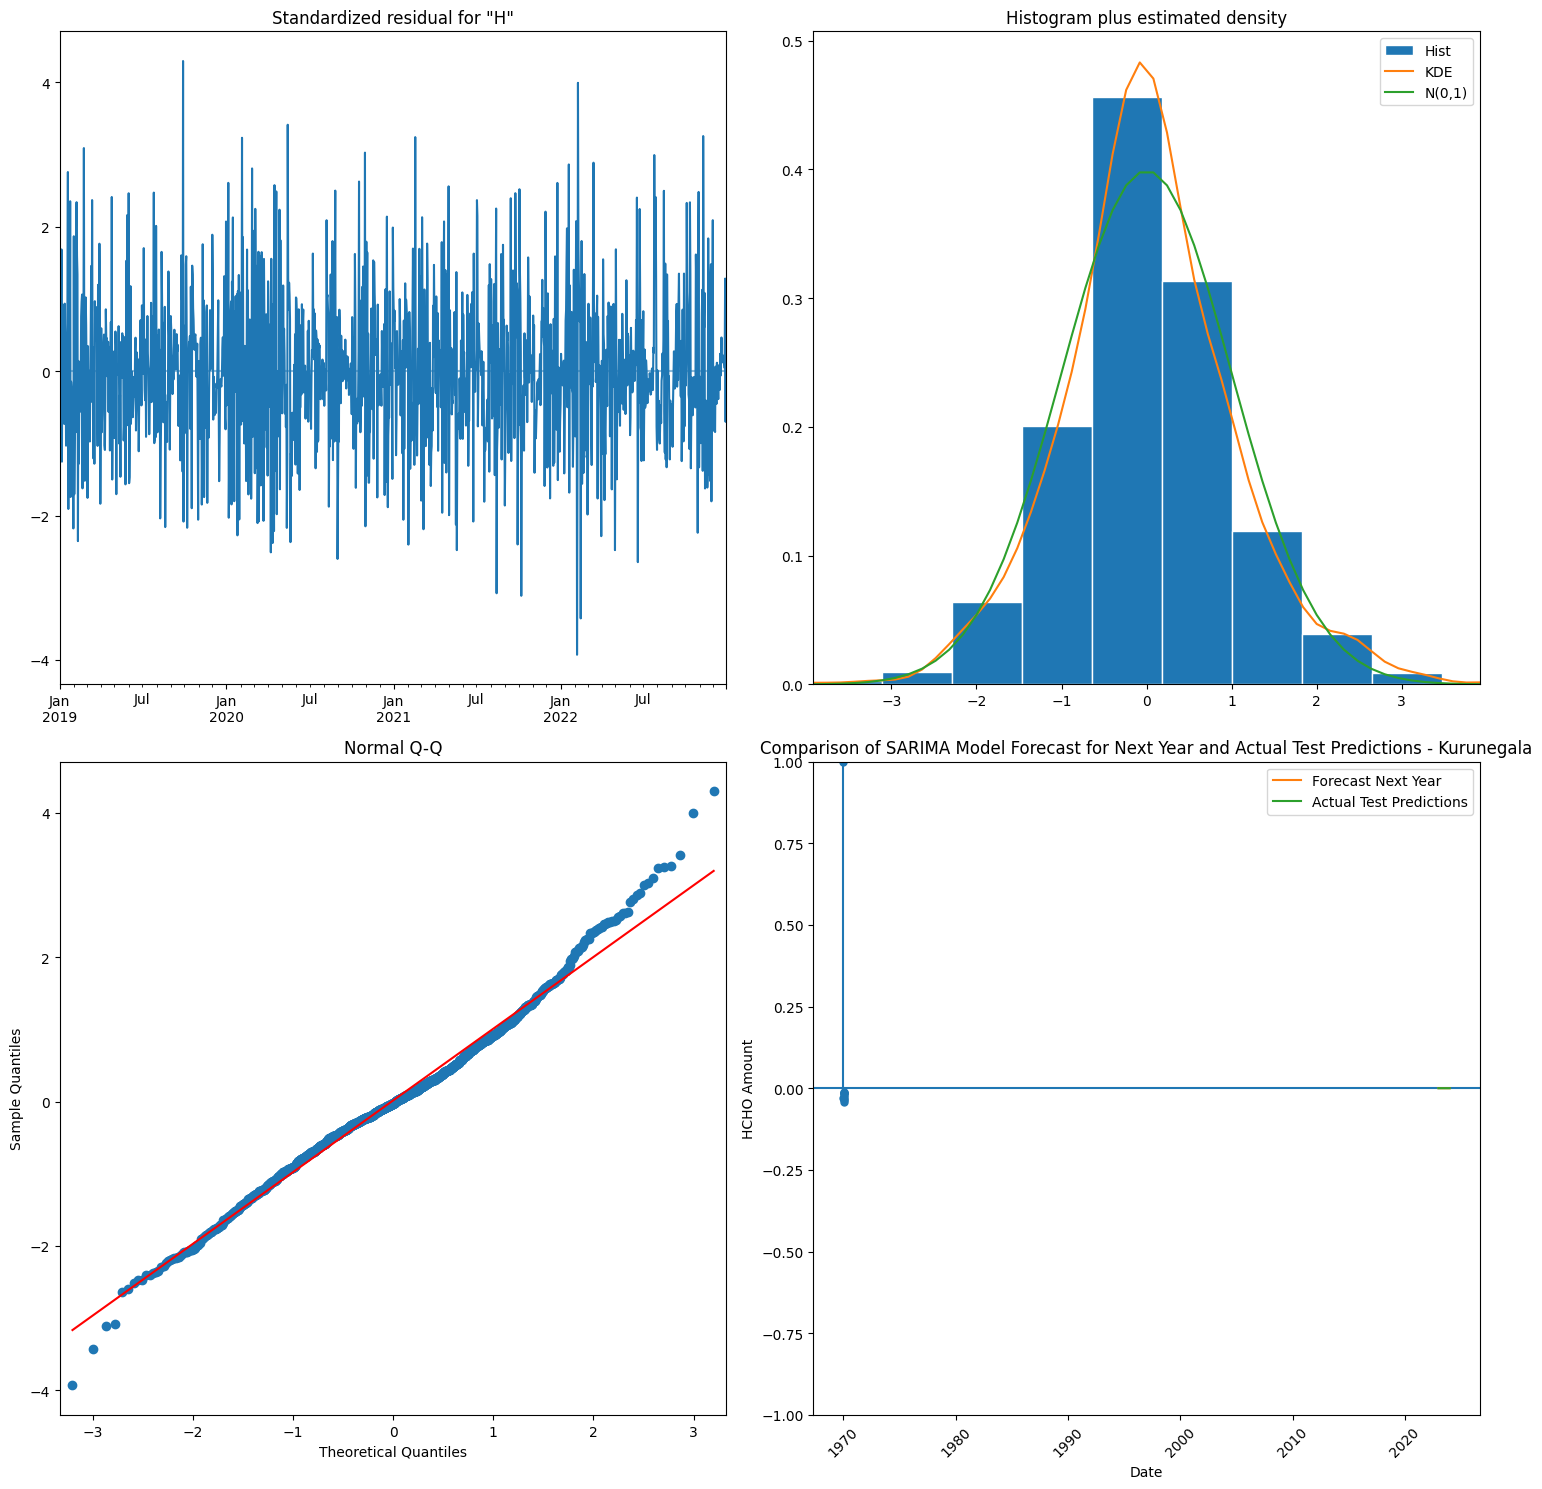


Processing data for Nuwara Eliya
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-24540.000, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-22025.198, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-24455.695, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-23144.130, Time=0.25 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-24519.970, Time=0.44 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-24529.618, Time=0.43 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-22015.185, Time=0.68 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-24533.853, Time=0.72 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-24500.107, Time=0.27 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-24534.325, Time=0.58 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-24494.434, Time=0.45 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-22013.185, Time=0.84 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-24627.775, Time=0.99 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : A

C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                       HCHO_reading   No. Observations:                 1460
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 12)   Log Likelihood               12044.940
Date:                            Sat, 20 Apr 2024   AIC                         -24079.879
Time:                                    19:50:40   BIC                         -24053.448
Sample:                                01-01-2019   HQIC                        -24070.019
                                     - 12-30-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7589   3.16e-19   2.41e+18      0.000       0.759       0.759
ar.L2          0.1571   2.28e-19   

C:\Users\benur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


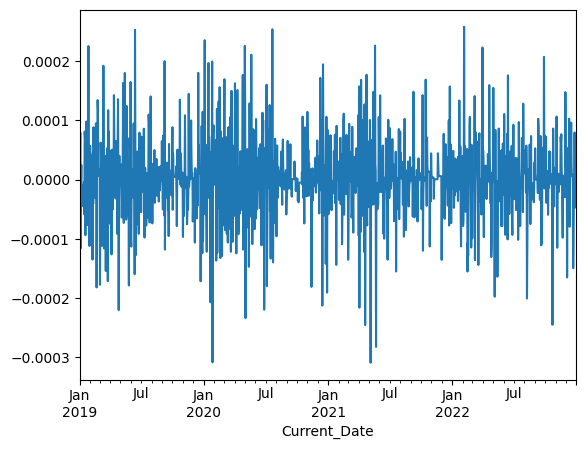

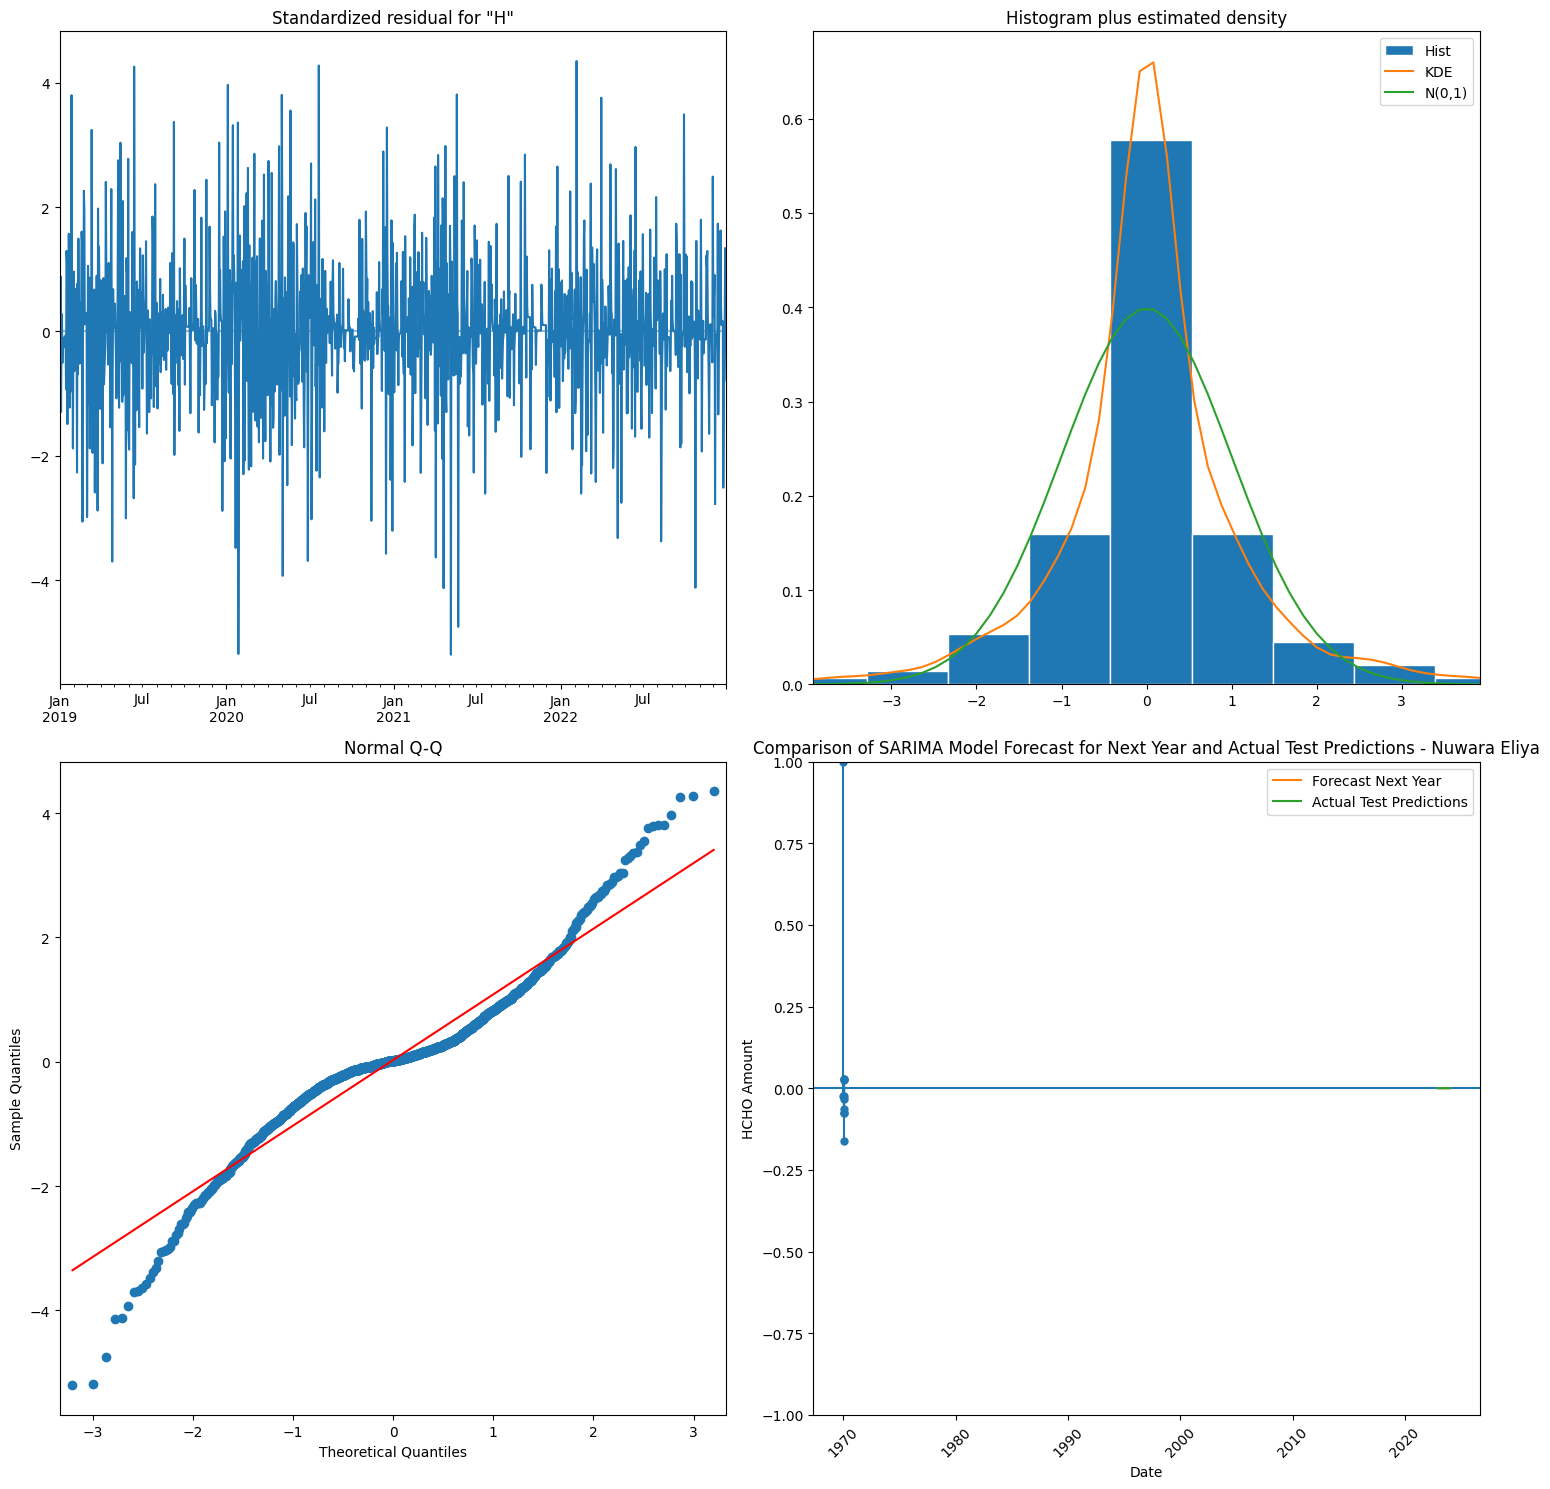

In [170]:
# Loop through each city
for city, df in dataframes.items():
    print(f"\nProcessing data for {city}")
    
    # convert 'Current_Date' dtype to datetime
    df['Current_Date'] = pd.to_datetime(df['Current_Date'])
    # drop unnecessary columns
    df = df.drop(['Location', 'Next_Date'], axis=1)
    # set 'Current_Date' as index
    df.set_index('Current_Date', inplace=True)
    # split data into training and testing sets
    train_size = 0.8
    train_data, test_data = train_test_split(df, train_size=train_size, shuffle=False)
    
    # fit auto-ARIMA model
    auto_arima_model = auto_arima(train_data, seasonal=False, trace=True)
    p, d, q = auto_arima_model.order
    print(f"Auto-ARIMA Order for {city}: {p}, {d}, {q}")
    
    # train SARIMA model with extracted order parameters
    sarima_model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(p, d, q, 12))
    sarima_fit = sarima_model.fit()
    print(sarima_fit.summary())
    
    # SARIMA model diagnostics
    sarima_residuals = sarima_fit.resid
    sarima_residuals.plot()
    sarima_fit.plot_diagnostics(figsize=(15, 15))
    
    # forecast using SARIMA model
    sarima_test_preds = sarima_fit.forecast(steps=len(test_data))
    print(sarima_test_preds)
    
    # calculate MSE
    sarima_mse = mean_squared_error(test_data['HCHO_reading'], sarima_test_preds)
    print(f'SARIMA MSE for {city}: {sarima_mse}')
    
    # calculate RMSE
    sarima_rmse = mean_squared_error(test_data['HCHO_reading'], sarima_test_preds, squared=False)
    print(f'SARIMA RMSE for {city}: {sarima_rmse}')
    
    # calculate MAE
    sarima_mae = mean_absolute_error(test_data['HCHO_reading'], sarima_test_preds)
    print(f'SARIMA MAE for {city}: {sarima_mae}')
    
    # forecast for next year
    forecast_steps = 365
    sarima_forecast_next_year = sarima_fit.forecast(steps=forecast_steps)
    print(sarima_forecast_next_year)
    
    # plot forecast and actual test predictions
    plt.plot(sarima_forecast_next_year.index, sarima_forecast_next_year.values, label='Forecast Next Year')
    plt.plot(test_data.index, test_data['HCHO_reading'], label='Actual Test Predictions')
    plt.xlabel('Date')
    plt.ylabel('HCHO Amount')
    plt.title(f'Comparison of SARIMA Model Forecast for Next Year and Actual Test Predictions - {city}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()